## Running multiple readouts

In [11]:
import readout as RO
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.integrate import ode, quad
from scipy.stats import norm
import numpy as np
from numpy import random

### Readout parameters

In [12]:
g = 45e6   # Transmon-cavity coupling strength (Hz)
delta = 380e6   # Transmon-cavity detuning (0z)
chi = 2*np.pi*g**2/delta
kappa = chi

alpha_0 = 0   # Initial cavity state
t_sim = 47530e-10 # Simulation time > 20/chi
dt = 1e-10   # Simulation timestep

freq_mm = 0   # Frequency mismatch between input signal and cavity (Hz)
A = 3   # Input signal amplitude

# Input signal (square pulse)
def b_in(t):

    # Pulse start time
    t0 = 100e-9
    
    # Pulse stop time
    tf = 2500e-9
    
    if t > t0 and t < tf:
        return A*np.exp(1j*2*np.pi*freq_mm*t)

    else:
        return 0 

t_wait = 5/kappa    # waiting time
t_acq = 20e-9    # sampling time
dt_acq = 1e-9    # sampling interval
Nt_acq = round(t_acq/dt_acq)


### Simulation

In [13]:
N = 1000

sim = RO.readout_simulation(b_in, freq_mm, chi, kappa, alpha_0, t_sim, dt)
int_theta_data, acq_steps_data, gaussian_fit, fidelity_matrices, acq_time = sim.do_multiple_readouts(N, t_wait, t_acq, dt_acq)

### Integrated noisy phase values and comparison to expected values
int_theta_data

sim.exp_theta

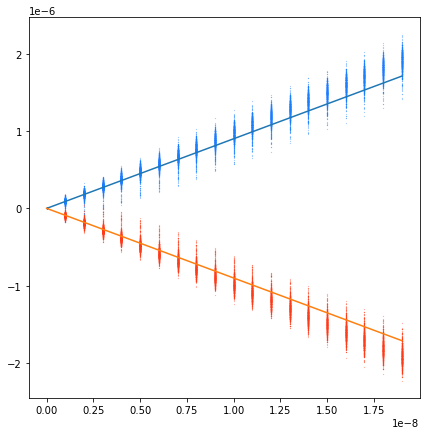

In [14]:
f, ax = plt.subplots(figsize=(7,7))

for n in range(N):
    ax.scatter(acq_time, int_theta_data['e'][n], label = 'excited', c = '#177FFF', s = 0.02)
    ax.scatter(acq_time, int_theta_data['g'][n], label = 'ground', c = '#FF3A17', s = 0.02)

# Plot theoretical expected values of integrated theta
plt.plot(acq_time, [sim.exp_theta['e']*dt_acq*i for i in range(len(acq_time))])
plt.plot(acq_time, [sim.exp_theta['g']*dt_acq*i for i in range(len(acq_time))])

plt.show()

### Histogram of integrated phase values and fit to gaussian as a function of acquisition steps
acq_steps_data

gaussian_fit

9.156735156865137e-08 -9.246655656433191e-08
1.8387636239673765e-07 -1.8602196053280187e-07
2.7822481025063026e-07 -2.806755422265113e-07


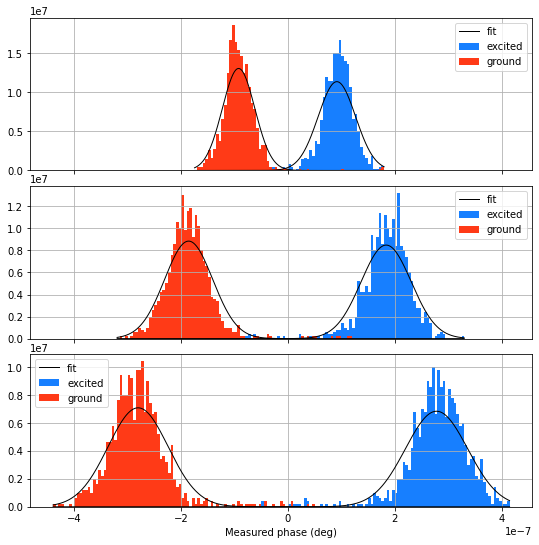

In [15]:
f, axes = plt.subplots(3, 1, sharex=True, figsize=(9,9))
f.subplots_adjust(hspace=0.1)

for n in range(3):
    # Fit data to normal distribution
    mu_e, std_e = gaussian_fit['e'][n+1]
    mu_g, std_g = gaussian_fit['g'][n+1]
    print(mu_e, mu_g)
    binwidth = 5e-9
    lim_min = np.ceil(np.array(acq_steps_data['e'][n+1] + acq_steps_data['g'][n+1]).min() / binwidth) * binwidth
    lim_max = np.ceil(np.array(acq_steps_data['e'][n+1] + acq_steps_data['g'][n+1]).max() / binwidth) * binwidth
    bins = np.arange(lim_min, lim_max + binwidth, binwidth)

    axes[n].hist(acq_steps_data['e'][n+1], density=True, color = '#177FFF', bins=bins, label = 'excited')
    axes[n].hist(acq_steps_data['g'][n+1], density=True, color = '#FF3A17', bins=bins, label = 'ground')

    x = np.linspace(lim_min, lim_max, 500)
    p_e = norm.pdf(x, mu_e, std_e)
    axes[n].plot(x, p_e, 'k', linewidth=1., label = 'fit')
    p_g = norm.pdf(x, mu_g, std_g)
    axes[n].plot(x, p_g, 'k', linewidth=1.)
    axes[n].grid()
    axes[n].legend()

axes[n].set_xlabel('Measured phase (deg)')
plt.show()

### Estimation of state discrimination fidelity using theoretical expected phase boundary
fidelity_matrices

sim.exp_theta

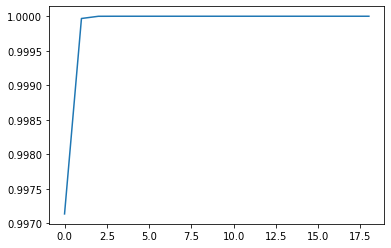

In [16]:
fidelity = []
for f_matrix in fidelity_matrices:
    fidelity.append(1 - (f_matrix[0][1] + f_matrix[1][0])/2)
    
plt.plot(fidelity)